### Detect Covid 19 from XRay
The objective of the notebook is to detect covid 19 from xray images. We would use pre trained model like VGG16, ResNet for model building. Extending pretrained model is called transfer learning.  A good tutorial on tranfer learning can be found  [here](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

In [1]:
## Let us import all the necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
        
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
import tensorflow

random_value=23
np.random.seed(random_value)
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten



/Users/sougatabhattacharya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NORMAL_XRAY_DIR = './input/chest-xray-pneumonia/chest_xray/train/NORMAL/'

In [3]:
print(len([name for name in os.listdir(NORMAL_XRAY_DIR) if os.path.isfile(os.path.join(NORMAL_XRAY_DIR, name))]))

1341


In [4]:
COVID_XRAY_DIR = './input/covid-chest-xray/images/'
print(len([name for name in os.listdir(COVID_XRAY_DIR) if os.path.isfile(os.path.join(COVID_XRAY_DIR, name))]))

314


### Copy only Xray Data
As suggested there are two types of images for covid, XRay or CT scan. I will copy only XRay data set.

In [5]:
COVID_DATA_PATH = './input/covid-chest-xray/'
dataset_path = './dataset'
def copy_covid_xray_data():
    # construct the path to the metadata CSV file and load it
    metadata_path = os.path.sep.join([COVID_DATA_PATH, "metadata.csv"])
    df = pd.read_csv(metadata_path)

    # loop over the rows of the COVID-19 data frame
    for (i, row) in df.iterrows():
        # if (1) the current case is not COVID-19 or (2) this is not
        # a 'PA' view, then ignore the row
        if row["finding"] != "COVID-19" or row["view"] != "PA":
            continue

        # build the path to the input image file
        imagePath = os.path.sep.join([COVID_DATA_PATH, "images", row["filename"]])

        # if the input image file does not exist (there are some errors in
        # the COVID-19 metadeta file), ignore the row
        if not os.path.exists(imagePath):
            continue

        # extract the filename from the image path and then construct the
        # path to the copied image file
        filename = row["filename"].split(os.path.sep)[-1]
        outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

        # copy the image
        shutil.copy2(imagePath, outputPath)


In [6]:
copy_covid_xray_data()

In [16]:
## Randomly shuffel the image Path.
random_value = 42
imagePaths = list(paths.list_images(NORMAL_XRAY_DIR))
random.seed(random_value) 
random.shuffle(imagePaths)

In [17]:
imagePaths = imagePaths[:127]
def copy_normal_xray():
    
    for (i, imagePath) in enumerate(imagePaths):
        # extract the filename from the image path and then construct the
        # path to the copied image file
        filename = imagePath.split(os.path.sep)[-1]
        outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

        # copy the image
        shutil.copy2(imagePath, outputPath)

In [18]:
copy_normal_xray()

### Plot Images
Let us plot images of both category.

In [11]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [19]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

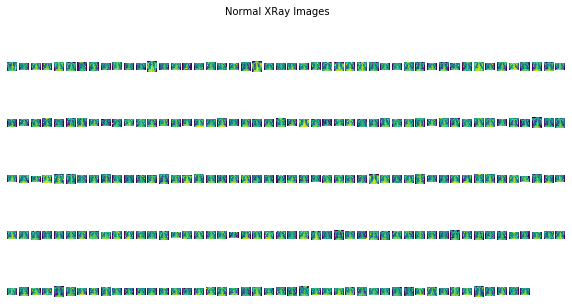

In [13]:
plots_from_files(normal_images,rows=5,maintitle="Normal XRay Images")
#plots_from_files(covid_images,rows=5,maintitle="Covid XRay Images")

In [20]:
# and batch size
INIT_LR = 1e-3
EPOCHS = 10  #15
BS = 8

In [21]:
path, dirs, files1 = next(os.walk("./dataset/covid/"))
print('#Covid Files : {0}',len(files1))
path, dirs, files2 = next(os.walk("./dataset/normal/"))
print('#Normal Files : {0}',len(files2))
print('Total files {0}: ',len(files1)+len(files2))

#Covid Files : {0} 127
#Normal Files : {0} 127
Total files {0}:  254


In [22]:
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [23]:
data.shape

(254, 224, 224, 3)

In [24]:
labels.shape

(254,)

In [25]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [26]:
labels.shape

(254, 2)

In [27]:
labels[0]

array([0., 1.], dtype=float32)

In [28]:
print("Total images = {} and labels = {}".format(len(data),len(labels)))

Total images = 254 and labels = 254


In [29]:
# the data for training and the remaining 15% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

Size of train image : 203 and train label : 203
Size of test image : 51 and test label : 51


In [30]:
covid = 0
for e in trainY:
    if e[0]==1:
        covid = covid+1

In [31]:
print('No of Covid Cases in training set = {0}',covid)

No of Covid Cases in training set = {0} 102


In [32]:
print('No of NON Covid Cases in training set = {0}',(len(trainY) - covid))

No of NON Covid Cases in training set = {0} 101


In [33]:
covid = 0
for e in testY:
    if e[0]==1:
        covid = covid+1
print('No of Covid Cases in test set = {0}',covid)
print('No of NON Covid Cases in test set = {0}',(len(testY) - covid))


No of Covid Cases in test set = {0} 25
No of NON Covid Cases in test set = {0} 26


### Transfer Learning 
Here we would use pre-trained model, VGG16

In [34]:
def build_vgg16_model():
    # load the VGG16 network, ensuring the head FC layer sets are left
    # off
    baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    return model

In [35]:
vgg16_model = build_vgg16_model()

In [36]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
vgg16_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]

# train the head of the network
print("[INFO] training head...")
vgg_history = vgg16_model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
25/25 [==============================] - 94s 4s/step - loss: 0.7101 - acc: 0.5856 - val_loss: 0.5458 - val_acc: 0.8431
Epoch 2/10
25/25 [==============================] - 100s 4s/step - loss: 0.5032 - acc: 0.7267 - val_loss: 0.4151 - val_acc: 0.9412
Epoch 3/10
25/25 [==============================] - 118s 5s/step - loss: 0.3756 - acc: 0.9199 - val_loss: 0.3386 - val_acc: 0.9020
Epoch 4/10
25/25 [==============================] - 111s 4s/step - loss: 0.2907 - acc: 0.9200 - val_loss: 0.2493 - val_acc: 0.9412
Epoch 5/10
25/25 [==============================] - 108s 4s/step - loss: 0.2223 - acc: 0.9599 - val_loss: 0.2123 - val_acc: 0.9020
Epoch 6/10
25/25 [==============================] - 107s 4s/step - loss: 0.2310 - acc: 0.9219 - val_loss: 0.1902 - val_acc: 0.9412
Epoch 7/10
25/25 [==============================] - 106s 4s/step - loss: 0.1610 - acc: 0.9750 - val_loss: 0.1762 - val_acc: 0.9216
Epoch 8/10
25/25 [================

In [38]:
def plot_model_performance(model_history):
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(['Train','Test'],loc='best')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train','Test'],loc='best')
    plt.show()

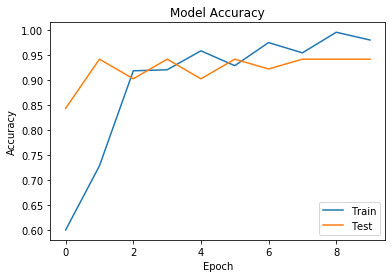

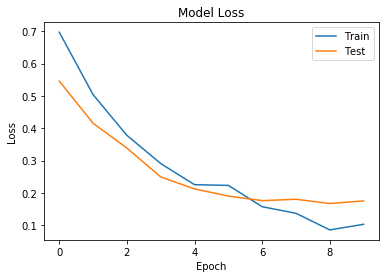

In [39]:
plot_model_performance(vgg_history)

In [44]:
def predict_test_set(model,testX,testY):
    # make predictions on the testing set
    print("[INFO] evaluating network...")
    predIdxs = model.predict(testX, batch_size=BS)
    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    predIdxs = np.argmax(predIdxs, axis=1)
    # show a nicely formatted classification report
    print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
    return predIdxs


In [45]:
predictions = predict_test_set(vgg16_model,testX,testY)

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.89      1.00      0.94        25
      normal       1.00      0.88      0.94        26

    accuracy                           0.94        51
   macro avg       0.95      0.94      0.94        51
weighted avg       0.95      0.94      0.94        51



In [48]:
def labels_data(predictions,values):
    labels=['covid','normal']
    plt.figure(figsize =(40,40))
    for i in range(40):
        plt.subplot(8,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title(labels[(np.argmax(values[i], axis=0))])
        plt.imshow(testX.reshape(-1,224,224,3)[i])

        if(predictions[i]==(np.argmax(values[i], axis=0))):
            plt.xlabel(labels[predictions[i]],color='blue')
        else:
            plt.xlabel(labels[predictions[i]],color='red')
    plt.show()

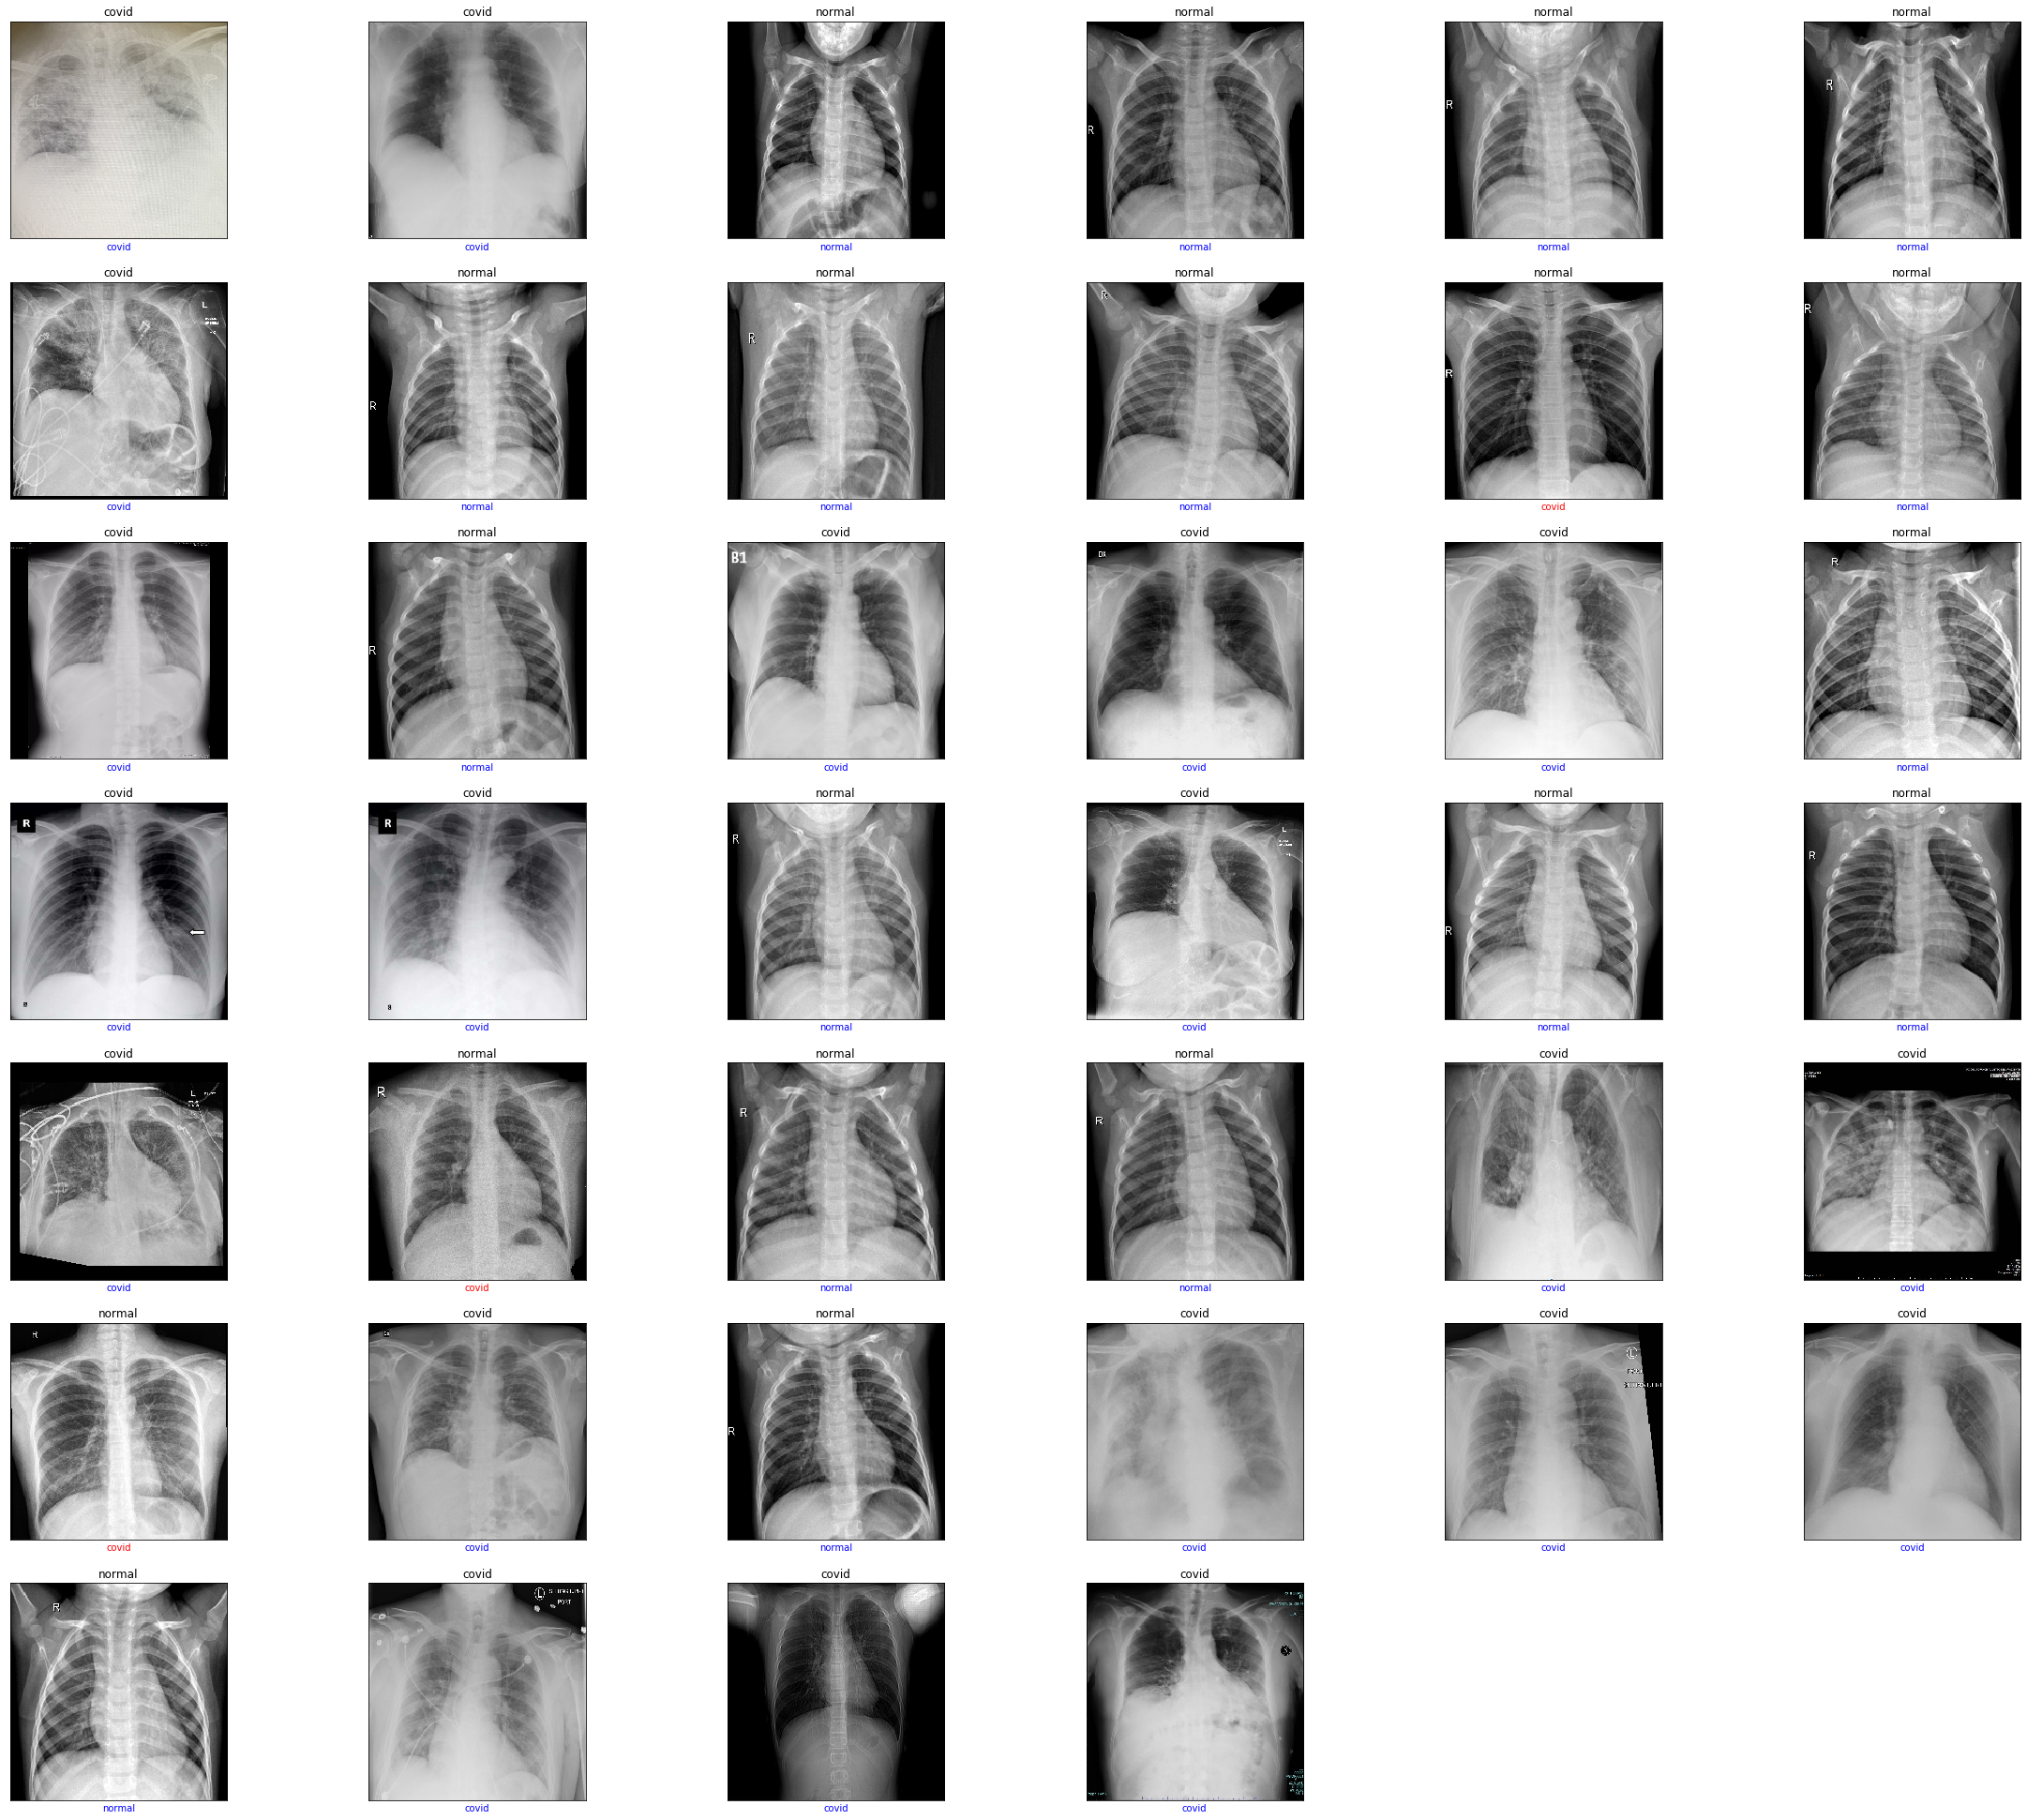

In [49]:
labels_data(predictions,testY)

### RestNet

In [66]:
def build_resnet():
     # load the VGG16 network, ensuring the head FC layer sets are left
    # off
    baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Flatten(name="flatten")(headModel)
    # add a fully-connected layer
    headModel = Dense(512, activation='relu')(headModel)
    headModel= Dropout(0.5)(headModel)
    # result = BatchNormalization()(result)
    headModel = Dense(256, activation='relu')(headModel)
    headModel= Dropout(0.3)(headModel)
    headModel = Dense(128, activation='relu')(headModel)
    # and a fully connected output/classification layer
    predictions = Dense(2, activation='sigmoid')(headModel)
    resnet_model = Model(inputs=baseModel.input, outputs=predictions)

    for layer in resnet_model.layers[0:141]:
        layer.trainable = False
    return resnet_model

In [67]:
resnet_model = build_resnet()
resnet_model.summary()

/Users/sougatabhattacharya/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [68]:
#### Run the model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='resnet_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]

# train the head of the network
print("[INFO] training head...")
resnet_history = resnet_model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
25/25 [==============================] - 58s 2s/step - loss: 0.1979 - acc: 0.9224 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 2/10
25/25 [==============================] - 47s 2s/step - loss: 0.0801 - acc: 0.9725 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 3/10
25/25 [==============================] - 49s 2s/step - loss: 0.1772 - acc: 0.9650 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 4/10
25/25 [==============================] - 50s 2s/step - loss: 0.3050 - acc: 0.9500 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 5/10
25/25 [==============================] - 51s 2s/step - loss: 0.0491 - acc: 0.9850 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 6/10
25/25 [==============================] - 163s 7s/step - loss: 0.2243 - acc: 0.9820 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 7/10
25/25 [==============================] - 50s 2s/step - loss: 0.2299 - acc: 0.9740 - val_loss: 8.1723 - val_acc: 0.4902
Epoch 8/10
25/25 [=====================

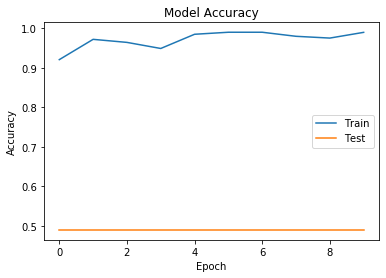

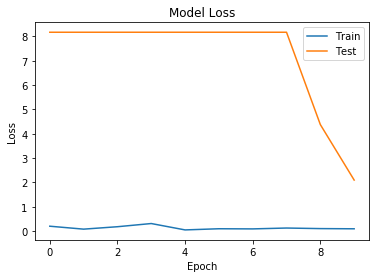

In [69]:
plot_model_performance(resnet_history)

In [71]:
predictions = predict_test_set(resnet_model,testX,testY)

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.49      1.00      0.66        25
      normal       0.00      0.00      0.00        26

    accuracy                           0.49        51
   macro avg       0.25      0.50      0.33        51
weighted avg       0.24      0.49      0.32        51



/Users/sougatabhattacharya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


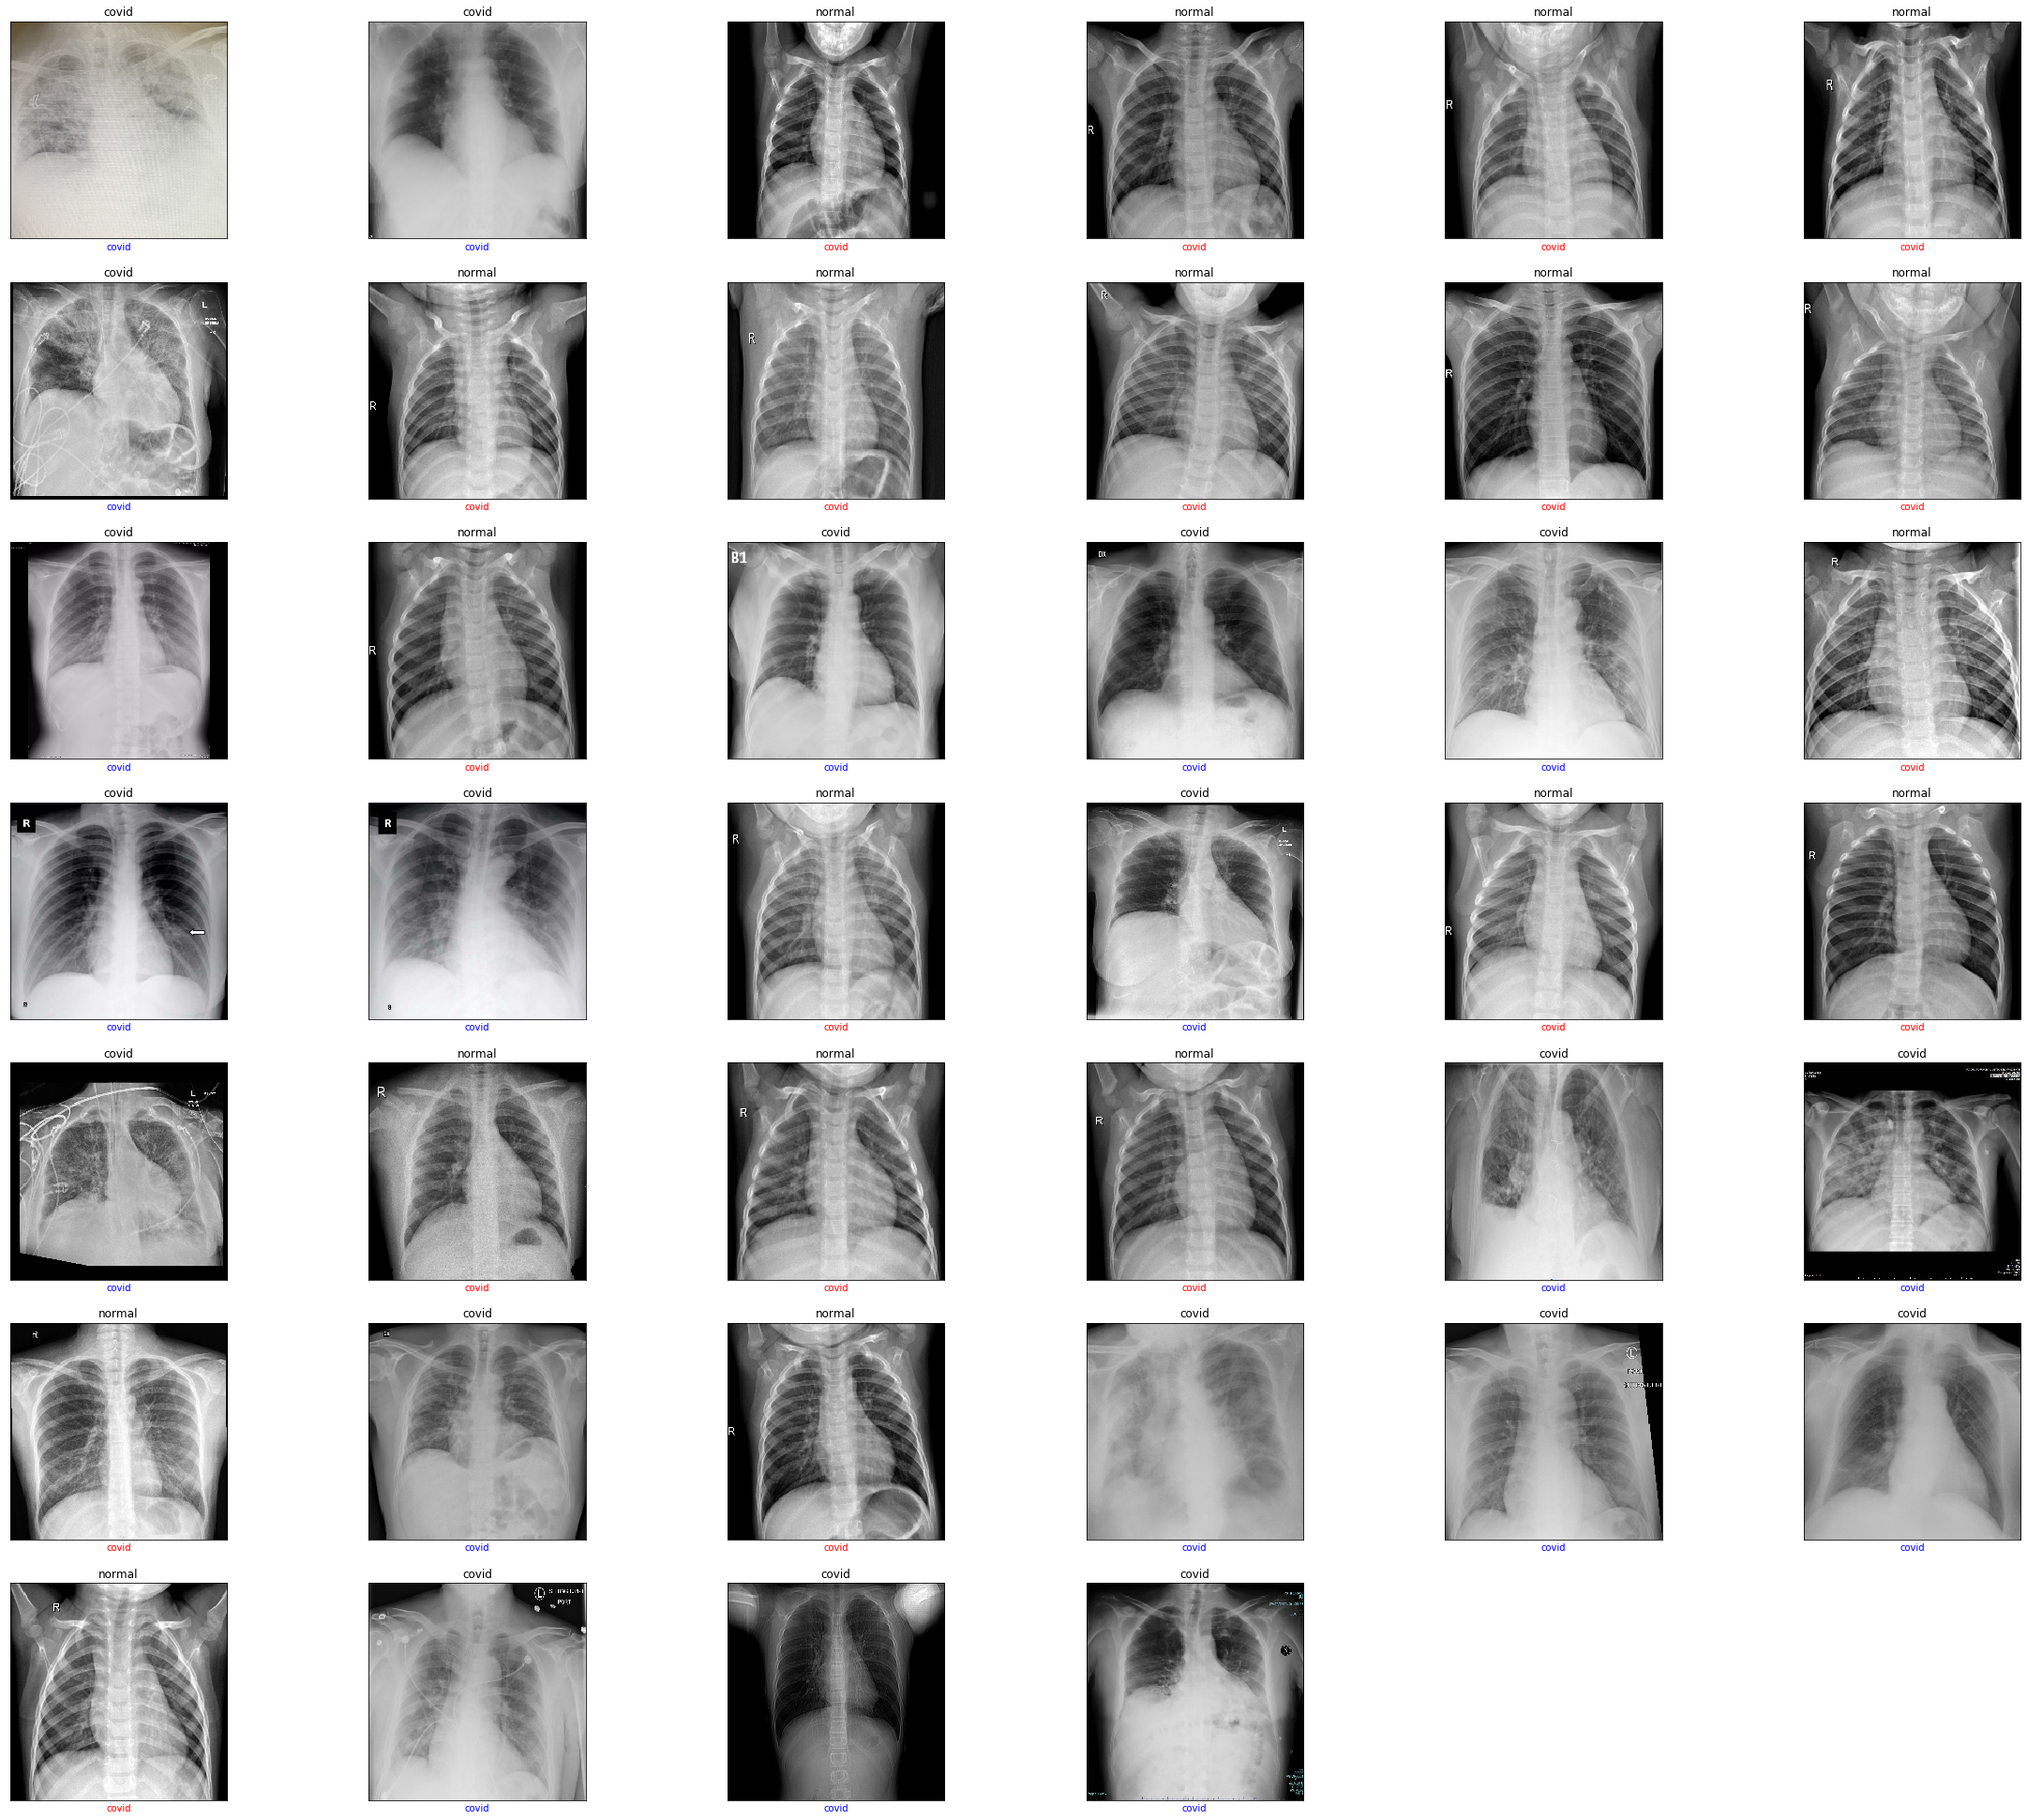

In [72]:
labels_data(predictions,testY)